# Intrusion detection

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges, e.g., various ''buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.



##  Data loading

In [2]:
# Here are some imports that are used along this notebook
import math
import itertools
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

In [3]:
import pyspark
from pyspark.sql import SQLContext, Row

# Creating local SparkContext with 8 threads and SQLContext based on it
#sc = pyspark.SparkContext(master='local[8]')
#sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

train20_nsl_kdd_dataset_path = "NSL_KDD_Dataset/KDDTrain+_20Percent.txt"
train_nsl_kdd_dataset_path = "NSL_KDD_Dataset/KDDTrain+.txt"
test_nsl_kdd_dataset_path = "NSL_KDD_Dataset/KDDTest+.txt"

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [5]:
# Function to load dataset and divide it into 8 partitions
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

## Label the attacks into four

 dividing connections into normal and attack classes based on 'labels' column. 
 Then attacks are splitted to four main categories: DoS, Probe, R2L and U2R. 
 After this, all of those categories are indexed. Also, ID column is added to simplify work with clustered data.

In [6]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

## Loading the training data

In [7]:
# Loading train data
t0 = time()
train_df = load_dataset(train_nsl_kdd_dataset_path)

# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

train_df = train_df.cache()
print(train_df.count())
print(time() - t0)

125973
33.16672110557556


## Loading the testing data

In [8]:
# Loading test data
t0 = time()
test_df = load_dataset(test_nsl_kdd_dataset_path)

# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(test_df.count())
print(time() - t0)

22544
2.1862149238586426


##  Data Analysis 

Here are some descriptive statistics of available features.

In [9]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [10]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



## Nominal columns

In [11]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [12]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [13]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

## Binary columns

In [14]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513094,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524175,0.0,1.0
root_shell,125973,0.0013415573178379495,0.03660284383979861,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.04515438381386557,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191085,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.09661232709143104,0.0,1.0


In [15]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [16]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

## Numeric Column

In [17]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867592,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893551,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414474,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.25352998595201254,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154243,0.0,3.0
hot,125973,0.20440888126820828,2.1499684337047587,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329835,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795125,0.0,7479.0
num_root,125973,0.30219173949973405,24.3996180888374,0.0,7468.0


In [18]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



As 'num_outbound_cmds' feature takes only 0.0 values, so it is dropped as redundant.

In [19]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

## One Hot Encoding for categorical variables

One Hot Encoding (OHE) is used for treating categorical variables. 

In [20]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [21]:
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(train_df.count())
print(time() - t0)

125973
24.569982528686523


Custom list of test binary cols is used as test dataset could contain additional categories for 'service' and 'flag' features. However, those additional categories aren't used below.

In [22]:
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(test_df.count())
print(time() - t0)

22544
17.808974981307983


## Feature Selection using Attribute Ratio

Attribute Ratio approach is used for feature selection purposes. 

In [25]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    '''
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        '''
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [26]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(len(ar_dict))
print(time() - t0)
ar_dict

31
6.017663955688477


OrderedDict([('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.756880682756574),
             ('dst_host_diff_srv_rate', 4.83734184897426),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378884017),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.069085485070395),
             ('dst_host_srv_rerror_rate', 3.667920527965924),
             ('srv_rerror_rate', 3.667741802325429),
             ('rerror_rate', 3.645586087828447),
             ('dst_host_rerror_rate', 3.2795669242444494),
             ('srv_diff_host_rate', 3.081565

##  Data preparation

Standartization is necessary as distance based algorithms are used below. 

In [43]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

125973
22544
4.798867464065552


In [39]:
scaled_train_df.show(10)

+---+--------------------+-------------+-------+-------------+-------+
| id|    indexed_features|labels2_index|labels2|labels5_index|labels5|
+---+--------------------+-------------+-------+-------------+-------+
|  0|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  1|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  2|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  3|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  4|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  5|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  6|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  7|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  8|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
| 10|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
+---+--------------------+-------------+-------+-------------+-------+
only s

In [40]:
scaled_test_df.show(10)

+---+--------------------+-------------+-------+-------------+-------+
| id|    indexed_features|labels2_index|labels2|labels5_index|labels5|
+---+--------------------+-------------+-------+-------------+-------+
|  0|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  1|[-0.0186098224759...|          1.0| attack|          1.0|    DoS|
|  2|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  3|[-0.0186098224759...|          1.0| attack|          2.0|  Probe|
|  4|[-0.0186098224759...|          1.0| attack|          2.0|  Probe|
|  5|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  6|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  7|[-0.0186098224759...|          1.0| attack|          3.0|    R2L|
|  8|[-0.0186098224759...|          0.0| normal|          0.0| normal|
|  9|[-0.0186098224759...|          1.0| attack|          3.0|    R2L|
+---+--------------------+-------------+-------+-------------+-------+
only s

VectorAssembler is used for combining a given list of columns into a single vector column. Then VectorIndexer is used for indexing categorical (binary) features. Indexing categorical features allows algorithms to treat them appropriately, improving performance.

In [44]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [56]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

100840
22544
3.1216485500335693


In [51]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


In [57]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

80754
20086


Additional "result" dataframes are used to collect probabilities and predictions from different approaches.

In [58]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

20086
22544


Different metrics from sklearn are used for evaluating results. The most important from them for this task are False positive Rate, 
Detection Rate and F1 score. 
and others

In [59]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

## Visualization via PCA

PCA algorithm is used for visualization purposes. 

First graph shows 'attack' vs 'normal' labels, second graph shows 4 different types of attacks vs normal connections.

In [60]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

t0 = time()
pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)
print(time() - t0)

4.291104078292847


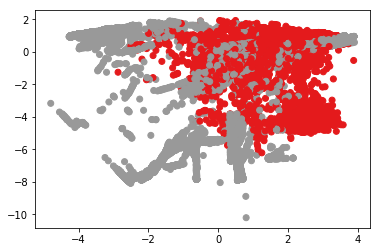

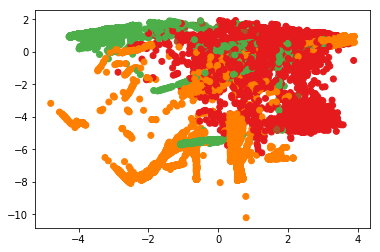

12.510819911956787


In [61]:
t0 = time()
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()
print(time() - t0)

##  KMeans clustering with Random Forest Classifiers

clusterize data into clusters and then train different Random Forest classifiers for each of the clusters. 

As KMeans cannot truly handle binary/categorical features only numeric features are used for clustarization.

In [62]:
kmeans_prob_col = 'kmeans_rf_prob'
kmeans_pred_col = 'kmeans_rf_pred'

prob_cols.append(kmeans_prob_col)
pred_cols.append(kmeans_pred_col)

In [63]:
# KMeans clustrering
from pyspark.ml.clustering import KMeans

t0 = time()
kmeans_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                             names=list(set(selectFeaturesByAR(ar_dict, 0.1)).intersection(numeric_cols)))

kmeans = KMeans(k=8, initSteps=25, maxIter=100, featuresCol="features", predictionCol="cluster", seed=seed)

kmeans_pipeline = Pipeline(stages=[kmeans_slicer, kmeans])

kmeans_model = kmeans_pipeline.fit(scaled_train_df)

kmeans_train_df = kmeans_model.transform(scaled_train_df).cache()
kmeans_cv_df = kmeans_model.transform(scaled_cv_df).cache()
kmeans_test_df = kmeans_model.transform(scaled_test_df).cache()

print(time() - t0)

13.42012882232666


In [67]:
# Function for describing the contents of the clusters 
def getClusterCrosstab(df, clusterCol='cluster'):
    return (df.crosstab(clusterCol, 'labels2')
              .withColumn('count', col('attack') + col('normal'))
              .withColumn(clusterCol + '_labels2', col(clusterCol + '_labels2').cast('int'))
              .sort(col(clusterCol +'_labels2').asc()))

In [68]:
kmeans_crosstab = getClusterCrosstab(kmeans_train_df).cache()
kmeans_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0|  3391| 39198|42589|
|              1|     0|    16|   16|
|              2| 22238|    70|22308|
|              3|     1|    32|   33|
|              4|  1730|    27| 1757|
|              5|  2976|   408| 3384|
|              6|  1918|  1472| 3390|
|              7|  5479|  1798| 7277|
+---------------+------+------+-----+



Clustres are splitted into two categories. Frist category contains clusters that have both 'attack' and 'normal' connections and have more than 25 connections. For the first category Random Forest classifiers are aplied. Second category contains all other clusters and maps cluster to 'attack' or 'normal' based on majority. All clusters that contains less or equal than 25 connections are treated as outliers and are mapped to 'attack' type.

In [69]:
# Function for splitting clusters
def splitClusters(crosstab):
    exp = ((col('count') > 25) & (col('attack') > 0) & (col('normal') > 0))

    cluster_rf = (crosstab
        .filter(exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), [row['count'], row['attack']/row['count']]))
        .collectAsMap())

    cluster_mapping = (crosstab
        .filter(~exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), 1.0 if (row['count'] <= 25) | (row['normal'] == 0) else 0.0))
        .collectAsMap())
    
    return cluster_rf, cluster_mapping

kmeans_cluster_rf, kmeans_cluster_mapping = splitClusters(kmeans_crosstab)

print(len(kmeans_cluster_rf), len(kmeans_cluster_mapping))
print(kmeans_cluster_mapping)
kmeans_cluster_rf

7 1
{1: 1.0}


{0: [42589, 0.07962149850900467],
 2: [22308, 0.9968621122467276],
 3: [33, 0.030303030303030304],
 4: [1757, 0.9846328969834945],
 5: [3384, 0.8794326241134752],
 6: [3390, 0.5657817109144543],
 7: [7277, 0.7529201594063488]}

In [70]:
from pyspark.ml.classification import RandomForestClassifier

# This function returns Random Forest models for provided clusters
def getClusterModels(df, cluster_rf):
    cluster_models = {}

    labels_col = 'labels2_cl_index'
    labels2_indexer.setOutputCol(labels_col)

    rf_slicer = VectorSlicer(inputCol="indexed_features", outputCol="rf_features", 
                             names=selectFeaturesByAR(ar_dict, 0.05))

    for cluster in cluster_rf.keys():
        t1 = time()
        rf_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                               numTrees=500, maxDepth=20, featureSubsetStrategy="sqrt")
        
        rf_pipeline = Pipeline(stages=[labels2_indexer, rf_slicer, rf_classifier])
        cluster_models[cluster] = rf_pipeline.fit(df.filter(col('cluster') == cluster))
        print("Finished %g cluster in %g ms" % (cluster, time() - t1))
        
    return cluster_models

In [72]:
# This utility function helps to get predictions/probabilities for the new data and return them into one dataframe
def getProbabilities(df, probCol, cluster_mapping, cluster_models):
    pred_df = (sqlContext.createDataFrame([], StructType([
                    StructField('id', LongType(), False),
                    StructField(probCol, DoubleType(), False)])))
    
    udf_map = udf(lambda cluster: cluster_mapping[cluster], DoubleType())
    pred_df = pred_df.union(df.filter(col('cluster').isin(list(cluster_mapping.keys())))
                            .withColumn(probCol, udf_map(col('cluster')))
                            .select('id', probCol))

                                       
    for k in cluster_models.keys():
        maj_label = cluster_models[k].stages[0].labels[0]
        udf_remap_prob = udf(lambda row: float(row[0]) if (maj_label == 'attack') else float(row[1]), DoubleType())

        pred_df = pred_df.union(cluster_models[k]
                         .transform(df.filter(col('cluster') == k))
                         .withColumn(probCol, udf_remap_prob(col('probability')))
                         .select('id', probCol))

    return pred_df

In [73]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
kmeans_cluster_models = getClusterModels(kmeans_train_df, kmeans_cluster_rf)
print(time() - t0)

Finished 0 cluster in 245.002 ms
Finished 2 cluster in 19.2376 ms
Finished 3 cluster in 1.80602 ms
Finished 4 cluster in 5.11852 ms
Finished 5 cluster in 17.8725 ms
Finished 6 cluster in 15.9974 ms
Finished 7 cluster in 22.1146 ms
327.1642394065857


In [74]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(kmeans_prob_col)
             .join(getProbabilities(kmeans_cv_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(time() - t0)

20086
103.0178701877594


In [75]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(kmeans_prob_col)
               .join(getProbabilities(kmeans_test_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(time() - t0)

22544
109.3117926120758


As CV data is from the same distribution as the train data it isn't needed to adjust threshold.

In [76]:
printReport(res_cv_df, kmeans_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 10881	    17	
attack	    25	  9163	
 
Accuracy = 0.997909
AUC = 0.99786
 
False Alarm Rate = 0.00155992
Detection Rate = 0.997279
F1 score = 0.997713
 
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     10898
        1.0       1.00      1.00      1.00      9188

avg / total       1.00      1.00      1.00     20086

 


Because test data is from the different distribution and it is expected to face unseen attack types, it makes sence to adjust a probability threshold to something like 0.01 for attack connections (0.99 for normal connections). For this approach it gives around ~98-99% Detection Rate with around ~14-15% of False Alarm Rate.

In [47]:
printReport(res_test_df, kmeans_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8262	  1449	
attack	   182	 12651	
 
Accuracy = 0.927653
AUC = 0.918303
 
False Alarm Rate = 0.149212
Detection Rate = 0.985818
F1 score = 0.939442
 
             precision    recall  f1-score   support

        0.0       0.98      0.85      0.91      9711
        1.0       0.90      0.99      0.94     12833

avg / total       0.93      0.93      0.93     22544

 


In [77]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(kmeans_pred_col, getPrediction(0.5)(col(kmeans_prob_col))).cache()
res_test_df = res_test_df.withColumn(kmeans_pred_col, getPrediction(0.01)(col(kmeans_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(time() - t0)

20086
22544
263.91791224479675


## Dettecting each type of attacks separately

The idea of the following approach is training Random Forest Classifiers for each of four major 'attack' categories separately.

### DoS and normal

In [78]:
dos_prob_col = 'dos_prob'
dos_pred_col = 'dos_pred'

prob_cols.append(dos_prob_col)
pred_cols.append(dos_pred_col)

In [79]:
dos_exp = (col('labels5') == 'DoS') | (col('labels5') == 'normal')
dos_train_df = (scaled_train_df.filter(dos_exp).cache())

print(dos_train_df.count())
(dos_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

72600
+-------+-----+
|labels5|count|
+-------+-----+
| normal|43021|
|    DoS|29579|
+-------+-----+



Diffirent AR feature selection is used as only normal and DoS connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [80]:
t0 = time()
dos_ar_dict = getAttributeRatio(train_df.filter(dos_exp), numeric_cols, binary_cols, 'labels5')

print(time() - t0)
dos_ar_dict

4.892829656600952


OrderedDict([('wrong_fragment', 2.4663052235068696),
             ('dst_host_srv_serror_rate', 2.4369460592636014),
             ('srv_serror_rate', 2.4091388710886883),
             ('serror_rate', 2.403031496724026),
             ('dst_host_serror_rate', 2.400741230991577),
             ('count', 2.0805650842389314),
             ('rerror_rate', 1.729470874459902),
             ('srv_rerror_rate', 1.7274542811973763),
             ('dst_host_srv_rerror_rate', 1.7208022988464688),
             ('dst_host_rerror_rate', 1.7204184332241286),
             ('num_failed_logins', 1.6819862494988345),
             ('num_root', 1.6819862494988345),
             ('urgent', 1.6819862494988342),
             ('num_file_creations', 1.6819862494988342),
             ('num_shells', 1.6819862494988342),
             ('num_access_files', 1.6819862494988342),
             ('duration', 1.6819438793516928),
             ('num_compromised', 1.639589690499449),
             ('dst_bytes', 1.6383223072580753

In [81]:
t0 = time()
dos_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                          names=selectFeaturesByAR(dos_ar_dict, 0.05))

dos_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                numTrees=500, maxDepth=20, seed=seed)

dos_rf_pipeline = Pipeline(stages=[dos_slicer, dos_rf])
dos_rf_model = dos_rf_pipeline.fit(dos_train_df)

dos_cv_df = dos_rf_model.transform(scaled_cv_df).cache()
dos_test_df = dos_rf_model.transform(scaled_test_df).cache()
print(dos_cv_df.count())
print(dos_test_df.count())

print(time() - t0)

20086
22544
196.19500946998596


In [94]:
dos_cv_df.select("features", "rawPrediction").show(10)

+--------------------+--------------------+
|            features|       rawPrediction|
+--------------------+--------------------+
|[-0.0894860668387...|[493.936174236423...|
|[-0.0894860668387...|[0.00337033482472...|
|[-0.0894860668387...|[499.999071494893...|
|[-0.0894860668387...|[499.955676541771...|
|[-0.0894860668387...|[499.999071494893...|
|[-0.0894860668387...|[1.75446645809417...|
|[-0.0894860668387...|[1.75446645809417...|
|[-0.0894860668387...|[1.75446645809417...|
|[-0.0894860668387...|[0.01652969884004...|
|[-0.0894860668387...|         [500.0,0.0]|
+--------------------+--------------------+
only showing top 10 rows



In [89]:
dos_test_df.select("features", "rawPrediction").show(10)

+--------------------+--------------------+
|            features|       rawPrediction|
+--------------------+--------------------+
|[-0.0894860668387...|[0.01652969884004...|
|[-0.0894860668387...|[0.03834788065822...|
|[-0.0894860668387...|         [500.0,0.0]|
|[-0.0894860668387...|[471.279262729950...|
|[-0.0894860668387...|        [484.0,16.0]|
|[-0.0894860668387...|         [500.0,0.0]|
|[-0.0894860668387...|         [497.0,3.0]|
|[-0.0894860668387...|[498.389793281653...|
|[-0.0894860668387...|         [500.0,0.0]|
|[-0.0894860668387...|         [500.0,0.0]|
+--------------------+--------------------+
only showing top 10 rows



In [90]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(dos_prob_col)
             .join(dos_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_cv_df.count())
print(time() - t0)

20086
105.67772817611694


In [92]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(dos_prob_col)
               .join(dos_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_test_df.count())
print(time() - t0)

22544
106.86261868476868


In [93]:
res_test_df.show(10)

+---+-------------+-------+-------+--------------------+--------------+--------------------+
| id|labels2_index|labels2|labels5|      kmeans_rf_prob|kmeans_rf_pred|            dos_prob|
+---+-------------+-------+-------+--------------------+--------------+--------------------+
|  0|          1.0| attack|    DoS|  0.9999906726341035|           1.0|  0.9999669406023199|
|  1|          1.0| attack|    DoS|   0.999950223923172|           1.0|  0.9999233042386835|
|  2|          0.0| normal| normal|0.001824135578193935|           0.0|                 0.0|
|  3|          1.0| attack|  Probe|  0.9130690507248003|           1.0|0.057441474540098375|
|  4|          1.0| attack|  Probe| 0.27753057889822597|           1.0|               0.032|
|  5|          0.0| normal| normal|                 0.0|           0.0|                 0.0|
|  6|          0.0| normal| normal|  0.1624893085106383|           1.0|               0.006|
|  7|          1.0| attack|    R2L|                 0.0|           0.0

The first report shows performance of classification for 'normal' and 'DoS' labels, the second report shows performance for the whole data with adjusted threshold.

In [95]:
printReport(res_cv_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_cv_df, probCol=dos_prob_col, e=0.05)

      	normal	   DoS	
normal	 10895	     3	
   DoS	     1	  7166	
 
Accuracy = 0.999779
AUC = 0.999793
 
False Alarm Rate = 0.00027528
Detection Rate = 0.99986
F1 score = 0.999721
 
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     10898
        1.0       1.00      1.00      1.00      7167

avg / total       1.00      1.00      1.00     18065

 
      	normal	attack	
normal	 10790	   108	
attack	   758	  8430	
 
Accuracy = 0.956885
AUC = 0.953796
 
False Alarm Rate = 0.00991008
Detection Rate = 0.917501
F1 score = 0.951145
 
             precision    recall  f1-score   support

        0.0       0.93      0.99      0.96     10898
        1.0       0.99      0.92      0.95      9188

avg / total       0.96      0.96      0.96     20086

 


In [96]:
printReport(res_test_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_test_df, probCol=dos_prob_col, e=0.01)

      	normal	   DoS	
normal	  9645	    66	
   DoS	  1656	  5802	
 
Accuracy = 0.899703
AUC = 0.88558
 
False Alarm Rate = 0.00679642
Detection Rate = 0.777957
F1 score = 0.870779
 
             precision    recall  f1-score   support

        0.0       0.85      0.99      0.92      9711
        1.0       0.99      0.78      0.87      7458

avg / total       0.91      0.90      0.90     17169

 
      	normal	attack	
normal	  8703	  1008	
attack	  2438	 10395	
 
Accuracy = 0.847143
AUC = 0.853111
 
False Alarm Rate = 0.1038
Detection Rate = 0.810021
F1 score = 0.857815
 
             precision    recall  f1-score   support

        0.0       0.78      0.90      0.83      9711
        1.0       0.91      0.81      0.86     12833

avg / total       0.86      0.85      0.85     22544

 


In [97]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(dos_pred_col, getPrediction(0.05)(col(dos_prob_col))).cache()
res_test_df = res_test_df.withColumn(dos_pred_col, getPrediction(0.01)(col(dos_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(time() - t0)

20086
22544
18.51946258544922


### Probe and normal

In [99]:
probe_prob_col = 'probe_prob'
probe_pred_col = 'probe_pred'

prob_cols.append(probe_prob_col)
pred_cols.append(probe_pred_col)

In [100]:
probe_exp = (col('labels5') == 'Probe') | (col('labels5') == 'normal')
probe_train_df = (scaled_train_df.filter(probe_exp).cache())

print(probe_train_df.count())
(probe_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

50520
+-------+-----+
|labels5|count|
+-------+-----+
| normal|43021|
|  Probe| 7499|
+-------+-----+



Diffirent AR feature selection is used as only normal and Probe connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [101]:
t0 = time()
probe_ar_dict = getAttributeRatio(train_df.filter(probe_exp), numeric_cols, binary_cols, 'labels5')

print(time() - t0)
probe_ar_dict

4.1574976444244385


OrderedDict([('dst_bytes', 5.954890189917854),
             ('src_bytes', 5.663342453521275),
             ('duration', 4.612329795738909),
             ('dst_host_diff_srv_rate', 4.295388446518038),
             ('srv_rerror_rate', 4.289248359824753),
             ('rerror_rate', 4.279060093009581),
             ('dst_host_srv_rerror_rate', 4.274560348159813),
             ('diff_srv_rate', 4.111925438331699),
             ('dst_host_rerror_rate', 4.008755744761299),
             ('dst_host_srv_diff_host_rate', 3.761764380647146),
             ('dst_host_srv_serror_rate', 3.5899755168448144),
             ('dst_host_same_src_port_rate', 3.260144247441684),
             ('serror_rate', 2.5392653643867047),
             ('count', 2.520990695784333),
             ('srv_serror_rate', 2.475062409348203),
             ('dst_host_serror_rate', 2.422128377779547),
             ('srv_diff_host_rate', 1.9745638565439239),
             ('urgent', 1.1730840621890917),
             ('num_access_fi

In [102]:
t0 = time()
probe_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                            names=selectFeaturesByAR(probe_ar_dict, 0.05))

probe_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                  numTrees=500, maxDepth=20, seed=seed)
probe_rf_pipeline = Pipeline(stages=[probe_slicer, probe_rf])

probe_rf_model = probe_rf_pipeline.fit(probe_train_df)

probe_cv_df = probe_rf_model.transform(scaled_cv_df).cache()
probe_test_df = probe_rf_model.transform(scaled_test_df).cache()

print(probe_cv_df.count())
print(probe_test_df.count())
print(time() - t0)

20086
22544
302.8170325756073


In [74]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(probe_prob_col)
             .join(probe_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(time() - t0)

25133
6.502754211425781


In [75]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(probe_prob_col)
               .join(probe_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(time() - t0)

22544
6.297783136367798


The first report shows performance of classification for 'normal' and 'Probe' labels, the second report shows performance for the whole data with adjusted threshold.

In [76]:
printReport(res_cv_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_cv_df, probCol=probe_prob_col, e=0.05)

      	normal	 Probe	
normal	 13322	     6	
 Probe	    12	  2373	
 
Accuracy = 0.998854
AUC = 0.997259
 
False Alarm Rate = 0.00045018
Detection Rate = 0.994969
F1 score = 0.996222
 
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     13328
        1.0       1.00      0.99      1.00      2385

avg / total       1.00      1.00      1.00     15713

 
      	normal	attack	
normal	 13127	   201	
attack	   430	 11375	
 
Accuracy = 0.974894
AUC = 0.974247
 
False Alarm Rate = 0.015081
Detection Rate = 0.963575
F1 score = 0.973012
 
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98     13328
        1.0       0.98      0.96      0.97     11805

avg / total       0.98      0.97      0.97     25133

 


In [77]:
printReport(res_test_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_test_df, probCol=probe_prob_col, e=0.01)

      	normal	 Probe	
normal	  9493	   218	
 Probe	   946	  1475	
 
Accuracy = 0.904055
AUC = 0.793402
 
False Alarm Rate = 0.0224488
Detection Rate = 0.609252
F1 score = 0.717064
 
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94      9711
        1.0       0.87      0.61      0.72      2421

avg / total       0.90      0.90      0.90     12132

 
      	normal	attack	
normal	  8416	  1295	
attack	  1969	 10864	
 
Accuracy = 0.855216
AUC = 0.856607
 
False Alarm Rate = 0.133354
Detection Rate = 0.846567
F1 score = 0.869398
 
             precision    recall  f1-score   support

        0.0       0.81      0.87      0.84      9711
        1.0       0.89      0.85      0.87     12833

avg / total       0.86      0.86      0.86     22544

 


In [78]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(probe_pred_col, getPrediction(0.05)(col(probe_prob_col))).cache()
res_test_df = res_test_df.withColumn(probe_pred_col, getPrediction(0.01)(col(probe_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(time() - t0)

25133
22544
7.390507459640503


### R2L, U2R and normal types

both R2L and U2R attack types have similar behaviour, they are combined into one group.

In [79]:
r2l_u2r_prob_col = 'r2l_u2r_prob'
r2l_u2r_pred_col = 'r2l_u2r_pred'

prob_cols.append(r2l_u2r_prob_col)
pred_cols.append(r2l_u2r_pred_col)

In [80]:
r2l_u2r_exp = (col('labels5') == 'R2L') | (col('labels5') == 'U2R') | (col('labels5') == 'normal')
r2l_u2r_train_df = (scaled_train_df.filter(r2l_u2r_exp).cache())

print(r2l_u2r_train_df.count())
(r2l_u2r_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

54834
+-------+-----+
|labels5|count|
+-------+-----+
| normal|54015|
|    R2L|  782|
|    U2R|   37|
+-------+-----+



Diffirent AR feature selection is used as only normal, R2L and U2R connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [81]:
t0 = time()
r2l_u2r_ar_dict = getAttributeRatio(train_df.filter(r2l_u2r_exp), numeric_cols, binary_cols, 'labels5')

print(time() - t0)
r2l_u2r_ar_dict

3.622958183288574


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 177.04511834319524),
             ('urgent', 93.9423076923077),
             ('flag_SF', 51.0),
             ('num_file_creations', 34.215028309254194),
             ('num_failed_logins', 25.660569514237856),
             ('hot', 23.850718086856727),
             ('src_bytes', 17.67531409051069),
             ('dst_bytes', 14.991946554922052),
             ('logged_in', 10.569767441860465),
             ('dst_host_same_src_port_rate', 4.6280053915595785),
             ('duration', 3.6136716211332516),
             ('dst_host_srv_diff_host_rate', 3.186499677327565),
             ('serror_rate', 2.8336950817010025),
             ('dst_host_srv_serror_rate', 2.550033066061569),
             ('num_access_files', 2.5488223017292784),
             ('num_compromised', 2.416504765066944),
             ('diff_srv_rate', 2.2340127157717946),
             ('service_telnet', 1.8888888888888888),
             ('dst_host_serror_

In [82]:
t0 = time()
r2l_u2r_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                              names=selectFeaturesByAR(r2l_u2r_ar_dict, 0.05))

r2l_u2r_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                    numTrees=500, maxDepth=20, seed=seed)
r2l_u2r_rf_pipeline = Pipeline(stages=[r2l_u2r_slicer, r2l_u2r_rf])

r2l_u2r_rf_model = r2l_u2r_rf_pipeline.fit(r2l_u2r_train_df)

r2l_u2r_cv_df = r2l_u2r_rf_model.transform(scaled_cv_df).cache()
r2l_u2r_test_df = r2l_u2r_rf_model.transform(scaled_test_df).cache()
print(r2l_u2r_cv_df.count())
print(r2l_u2r_test_df.count())

print(time() - t0)

25133
22544
142.93370270729065


In [83]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(r2l_u2r_prob_col)
             .join(r2l_u2r_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(time() - t0)

25133
6.968761205673218


In [84]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(r2l_u2r_prob_col)
               .join(r2l_u2r_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(time() - t0)

22544
6.208894729614258


The first report shows performance of classification for 'normal' and 'R2L&U2R' labels, the second report shows performance for the whole data with adjusted threshold.

In [85]:
printReport(res_cv_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_cv_df, probCol=r2l_u2r_prob_col, e=0.05, labels=labels2)

       	 normal	R2L&U2R	
 normal	  13324	      4	
R2L&U2R	     14	    214	
 
Accuracy = 0.998672
AUC = 0.969148
 
False Alarm Rate = 0.00030012
Detection Rate = 0.938596
F1 score = 0.959641
 
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     13328
        1.0       0.98      0.94      0.96       228

avg / total       1.00      1.00      1.00     13556

 
      	normal	attack	
normal	 13245	    83	
attack	  4361	  7444	
 
Accuracy = 0.823181
AUC = 0.812176
 
False Alarm Rate = 0.00622749
Detection Rate = 0.63058
F1 score = 0.770122
 
             precision    recall  f1-score   support

        0.0       0.75      0.99      0.86     13328
        1.0       0.99      0.63      0.77     11805

avg / total       0.86      0.82      0.82     25133

 


In [86]:
printReport(res_test_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_test_df, probCol=r2l_u2r_prob_col, e=0.01, labels=labels2)

       	 normal	R2L&U2R	
 normal	   9709	      2	
R2L&U2R	   2727	    227	
 
Accuracy = 0.784524
AUC = 0.53832
 
False Alarm Rate = 0.000205952
Detection Rate = 0.076845
F1 score = 0.142633
 
             precision    recall  f1-score   support

        0.0       0.78      1.00      0.88      9711
        1.0       0.99      0.08      0.14      2954

avg / total       0.83      0.78      0.71     12665

 
      	normal	attack	
normal	  9403	   308	
attack	  5858	  6975	
 
Accuracy = 0.72649
AUC = 0.755902
 
False Alarm Rate = 0.0317166
Detection Rate = 0.543521
F1 score = 0.693478
 
             precision    recall  f1-score   support

        0.0       0.62      0.97      0.75      9711
        1.0       0.96      0.54      0.69     12833

avg / total       0.81      0.73      0.72     22544

 


In [87]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(r2l_u2r_pred_col, getPrediction(0.05)(col(r2l_u2r_prob_col))).cache()
res_test_df = res_test_df.withColumn(r2l_u2r_pred_col, getPrediction(0.01)(col(r2l_u2r_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(time() - t0)

25133
22544
6.978176593780518


### Combining results

In [88]:
sup_prob_col = 'sup_prob'
sup_pred_col = 'sup_pred'

prob_cols.append(sup_prob_col)
pred_cols.append(sup_pred_col)

In [89]:
res_cv_df = res_cv_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_cv_df, sup_prob_col, e=0.05, labels=labels2)

      	normal	attack	
normal	 13195	   133	
attack	     2	 11803	
 
Accuracy = 0.994629
AUC = 0.994926
 
False Alarm Rate = 0.00997899
Detection Rate = 0.999831
F1 score = 0.994314
 
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     13328
        1.0       0.99      1.00      0.99     11805

avg / total       0.99      0.99      0.99     25133

 


In [90]:
res_cv_df = res_cv_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                        .bitwiseOR(col(probe_pred_col).cast('int'))
                                        .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_cv_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	 13011	   317	
attack	     0	 11805	
 
Accuracy = 0.987387
AUC = 0.988108
 
False Alarm Rate = 0.0237845
Detection Rate = 1
F1 score = 0.986751
 
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     13328
        1.0       0.97      1.00      0.99     11805

avg / total       0.99      0.99      0.99     25133

 


In [91]:
res_test_df = res_test_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_test_df, sup_prob_col, e=0.005, labels=labels2)

      	normal	attack	
normal	  8367	  1344	
attack	   830	 12003	
 
Accuracy = 0.903566
AUC = 0.898462
 
False Alarm Rate = 0.1384
Detection Rate = 0.935323
F1 score = 0.91696
 
             precision    recall  f1-score   support

        0.0       0.91      0.86      0.89      9711
        1.0       0.90      0.94      0.92     12833

avg / total       0.90      0.90      0.90     22544

 


In [92]:
res_test_df = res_test_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                            .bitwiseOR(col(probe_pred_col).cast('int'))
                                            .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_test_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	  8302	  1409	
attack	   728	 12105	
 
Accuracy = 0.905208
AUC = 0.899089
 
False Alarm Rate = 0.145093
Detection Rate = 0.943271
F1 score = 0.91889
 
             precision    recall  f1-score   support

        0.0       0.92      0.85      0.89      9711
        1.0       0.90      0.94      0.92     12833

avg / total       0.91      0.91      0.90     22544

 


### Stacking with Random Forest Classifier

In [104]:
stack_cv_df = scaled_cv_df.join(res_cv_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

stack_test_df = scaled_test_df.join(res_test_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

print(stack_cv_df.count())
print(stack_test_df.count())

25133
22544


In [105]:
t0 = time()
pred_assembler = VectorAssembler(inputCols=[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ], outputCol='pred_features')
pred_indexer = VectorIndexer(inputCol='pred_features', outputCol='indexed_pred_features', maxCategories=2)

rf_stack_slicer = VectorSlicer(inputCol='indexed_features', outputCol='selected_features', 
                               names=selectFeaturesByAR(ar_dict, 1.5))

rf_stack_assembler = VectorAssembler(inputCols=['selected_features', 'indexed_pred_features'], outputCol='rf_features')

rf_stack_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                             numTrees=500, maxDepth=20, featureSubsetStrategy="auto")

stack_pipeline = Pipeline(stages=[pred_assembler, 
                                  pred_indexer, 
                                  rf_stack_slicer, 
                                  rf_stack_assembler,
                                  rf_stack_classifier
                                 ])
stack_model = stack_pipeline.fit(stack_cv_df)

pred_stack_cv_df = stack_model.transform(stack_cv_df).cache()
pred_stack_test_df = stack_model.transform(stack_test_df).cache()
print(pred_stack_cv_df.count())
print(pred_stack_test_df.count())

print(time() - t0)

25133
22544
68.9830629825592


In [106]:
t0 = time()
res_cv_df = res_cv_df.drop('prob_stack_rf')
res_cv_df = (res_cv_df.join(pred_stack_cv_df.rdd
                            .map(lambda row: (row['id'], float(row['probability'][1])))
                            .toDF(['id', 'prob_stack_rf']),
                            'id')
                        .cache())

print(res_cv_df.count())
print(time() - t0)

25133
7.56744384765625


In [107]:
t0 = time()
res_test_df = res_test_df.drop('prob_stack_rf')
res_test_df = (res_test_df.join(pred_stack_test_df.rdd
                            .map(lambda row: (row['id'], float(row['probability'][1])))
                            .toDF(['id', 'prob_stack_rf']),
                            'id')
                        .cache())

print(res_test_df.count())
print(time() - t0)

22544
7.081209421157837


In [108]:
printReport(res_test_df, 'prob_stack_rf', e=0.01, labels=labels2)

      	normal	attack	
normal	  8140	  1571	
attack	    88	 12745	
 
Accuracy = 0.926411
AUC = 0.915684
 
False Alarm Rate = 0.161775
Detection Rate = 0.993143
F1 score = 0.938893
 
             precision    recall  f1-score   support

        0.0       0.99      0.84      0.91      9711
        1.0       0.89      0.99      0.94     12833

avg / total       0.93      0.93      0.93     22544

 


In [109]:
print(time() - gt0)

1407.712391614914


## Results summary

The best result from a single approach was achieved by KMeans Clustering with Random Forest Classifiers. It gives 
around ~98-99% of detection rate with reasonable ~14-15% of false alarm rate. F1 score is 0.94, weighted F1 score is 0.93.

